## Optional analysis of the labels we are left with after the initial filtering pass
Labels are generated in the candidate_label_creation notebook and then filtered in the candidate_filter notebook.

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation and candidate_filter notebooks before this notebook.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utility import run_command

### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation and candidate_filter notebooks. This should contain a folder called label_creation and a folder called candidate_filter.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.  
*label_file*: file path for the file that contains wikidata labels.

In [2]:
# **REQUIRED**
work_dir = "../../Q154/profiler_work"
store_dir = "../../Q154"
label_file = "../../Q154/data/labels.en.tsv.gz"

### Process params / set up variables

In [3]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
label_file = os.path.abspath(label_file)

label_creation_dir = "{}/label_creation".format(work_dir)
filter_dir = "{}/candidate_filter".format(work_dir)
    
# Create output directory
output_dir = "{}/analyze_filtered_labels".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = label_creation_dir
os.environ['FILTERED_LABELS'] = filter_dir
os.environ['LABEL_FILE'] = label_file
os.environ["OUT"] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## pre-processing...
To make labels easier to look through, we'll:
1. Add human readable labels* for Wikidata nodes and properties.
2. Add a label-kind column to our labels so that we can key on this after we combine the labels into a single table.
3. Add a column for number of entities of type = label's type
4. Standardize/disambiguate column headers across label kinds so they can be combined into a single table.

*sorry for the ambiguous wording here - "labels" in this sentence refers to a different thing than the labels we are analyzing in this notebook

**AVLs**

In [4]:
if not os.path.isfile("{}/candidate_labels_avl_string_filtered.tsv".format(filter_dir)):
    string_file_exists = False
    print("No string labels file found, skipping this step.")
else:
    string_file_exists = True
    # perform query
    command = "$kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_string_filtered.tsv \
               -i LABEL_FILE -o $OUT/filtered_avl_string_analysis.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `LABEL_FILE`: (type)-[]->(type_lab)' \
               --return 'distinct \"AVL\" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, \"\" as val1_lab, \"\" as val1_ub, \"\" as type2, \"\" as type2_lab, \"\" as prop2, \"\" as prop2_lab, \"\" as val2, \"\" as val2_ub, \"\" as si_units, \"\" as wd_units' \
               --where 'type_lab.kgtk_lqstring_lang_suffix = \"en\"'"
    run_command(command, {"LABEL_FILE" : label_file})

In [5]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [6]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RELs**

In [7]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rel_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab), `'"$LABEL_FILE"'`: (val)-[]->(val_lab)' \
--return 'distinct "REL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, val_lab as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND val_lab.kgtk_lqstring_lang_suffix = "en"'

**AILs**

In [8]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, upper_bound:ub, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [9]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, upper_bound:ub, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RAVLs**

In [10]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ravl_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, val:val2, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, val2 as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


**RAILs**

In [11]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rail_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, lb as val2, ub as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


Defining filename variables and the order of columns in our analysis files since we'll need thess in a couple places.

In [12]:
if string_file_exists:
    avl_string_file = "{}/filtered_avl_string_analysis.tsv".format(output_dir)
avl_quantity_file = "{}/filtered_avl_quantity_analysis.tsv".format(output_dir)
avl_year_file = "{}/filtered_avl_time.year_analysis.tsv".format(output_dir)
rel_file = "{}/filtered_rel_analysis.tsv".format(output_dir)
ail_quantity_file = "{}/filtered_ail_quantity_analysis.tsv".format(output_dir)
ail_year_file = "{}/filtered_ail_time.year_analysis.tsv".format(output_dir)
ravl_file = "{}/filtered_ravl_analysis.tsv".format(output_dir)
rail_file = "{}/filtered_rail_analysis.tsv".format(output_dir)
all_file = "{}/filtered_all_analysis.tsv".format(output_dir)

all_cols = ["label_kind","positives", "num_type1_ents", "support", "type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "val1_ub", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units"]
avl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "si_units", "wd_units","positives", "num_type1_ents", "support"]
rel_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "positives", "num_type1_ents", "support"]
ail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
ravl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
rail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]


Creating a combined analysis files

In [13]:
df = pd.read_csv(avl_quantity_file, delimiter = '\t')
if string_file_exists:
    df = df.append(pd.read_csv(avl_string_file, delimiter = '\t'))
df = df.append(pd.read_csv(avl_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(rel_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_quantity_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(ravl_file, delimiter = '\t'))
df = df.append(pd.read_csv(rail_file, delimiter = '\t'))

df[all_cols].to_csv(path_or_buf = all_file, sep = '\t', index = False)

Helper function for viewing label support / positives distribution

In [41]:
"""
Given a file containing labels, optionally filter by the labels' type1,
plot label support and label count histograms, and print out some examples
of labels at various bins of the histograms.
"""
def plot_label_supports_and_positives(filename, cols_to_print_in_order, type1 = None,
                                      log_scale_supports = False, log_scale_positives = False):
    df = pd.read_csv(filename, delimiter = '\t')
    # We get NA when reading blank cells.
    # Blank cells are expected, so we'll change them back to avoid confusion when displaying
    df.fillna("", inplace = True) 
    
    if type1 is not None:
        df = df.loc[df.loc[:,"type1"] == type1]
        
    if df.empty:
        print("There are no labels in the given file with type = {}".format(type1))
        return
        
    supports = df.loc[:,"support"]
    positives = df.loc[:,"positives"]
    
    fig, (ax_sup, ax_pos) = plt.subplots(1, 2, figsize = (14,5))
    
    ax_sup.hist(supports, bins = np.arange(0,1.01,.02))
    ax_sup.set_xlabel("Support (# positives for this label / # entities with this label's type)")
    ax_sup.set_ylabel("# Labels")
    ax_sup.set_title("Distribution of Support for Labels")
    if log_scale_supports:
        ax_sup.set_yscale("log")
    
    ax_pos.hist(positives, bins = range(0,max(positives)+2,1), align = "left")
    ax_pos.set_xlabel("# Positives")
    ax_pos.set_ylabel("# Labels")
    ax_pos.set_title("Distribution of Number of Positives for Labels")
    if log_scale_positives:
        ax_pos.set_yscale("log")
 
    plt.tight_layout()
    plt.show()
    
    # Show some examples of labels in various bins of the histograms
    
    print("Examples of labels at several values of support...")
    unique_supports_sorted = sorted(set(supports))
    examples_df = pd.DataFrame()
    num_to_show = 5
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        sup = unique_supports_sorted[int((i/4) * (len(unique_supports_sorted)-1))]
        if sup not in num_shown_from_bin:
            num_shown_from_bin[sup] = 0
        ix_to_choose = num_shown_from_bin[sup]
        examples_in_bin = df.loc[df.loc[:,"support"] == sup]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[sup] += 1
    display(examples_df[cols_to_print_in_order])
        
    print("\nExamples of labels at several values of positives...")
    unique_positives_sorted = sorted(set(positives))
    examples_df = pd.DataFrame()
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        pos = unique_positives_sorted[int((i/4) * (len(unique_positives_sorted)-1))]
        if pos not in num_shown_from_bin:
            num_shown_from_bin[pos] = 0
        ix_to_choose = num_shown_from_bin[pos]
        examples_in_bin = df.loc[df.loc[:,"positives"] == pos]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[pos] += 1
    display(examples_df[cols_to_print_in_order])

### AVL - string

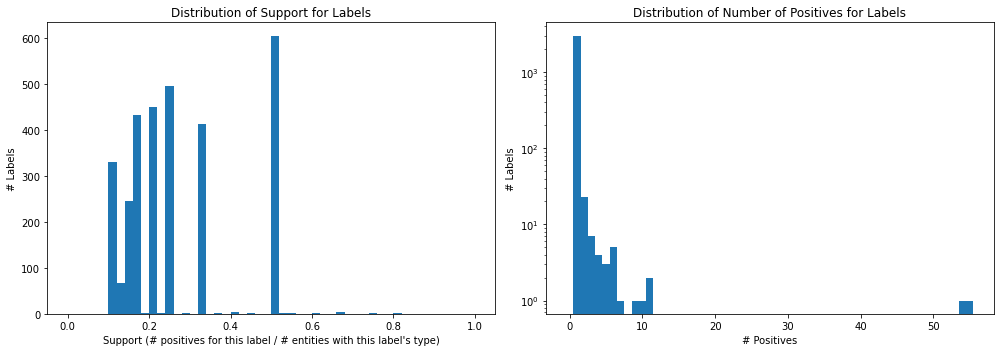

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q123480,'landlocked country'@en,P3238,'trunk prefix'@en,8,,,2.0,20.0,0.100000
398,Q18636219,'Wikidata property with datatype \\\\'time\\\\...,P1282,'OpenStreetMap tag or key'@en,Key:end_date,,,2.0,14.0,0.142857
1531,Q33146843,'municipality of Catalonia'@en,P395,'licence plate code'@en,B,,,3.0,12.0,0.250000
3050,Q3624078,'sovereign state'@en,P3238,'trunk prefix'@en,0,,,54.0,104.0,0.519231
3062,Q1520223,'constitutional republic'@en,P3238,'trunk prefix'@en,0,,,4.0,5.0,0.800000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
2,Q146470,'brandy'@en,P373,'Commons category'@en,Armenian cognac,,,1.0,10.0,0.100000
1531,Q33146843,'municipality of Catalonia'@en,P395,'licence plate code'@en,B,,,3.0,12.0,0.250000
643,Q747074,'comune of Italy'@en,P395,'licence plate code'@en,PA,,,6.0,39.0,0.153846
3052,Q179164,'unitary state'@en,P3238,'trunk prefix'@en,0,,,10.0,19.0,0.526316
3051,Q6256,'country'@en,P3238,'trunk prefix'@en,0,,,55.0,105.0,0.523810


In [15]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, log_scale_positives = True)

### AVL - year

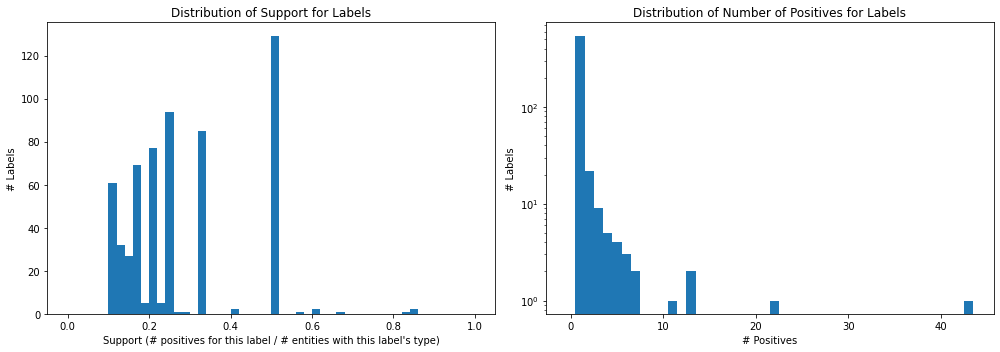

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q123480,'landlocked country'@en,P571,'inception'@en,1918.0,,,2.0,20.0,0.100000
91,Q112099,'island nation'@en,P7295,'Gregorian calendar start date'@en,1752.0,,,2.0,15.0,0.133333
192,Q1565828,'appellation d\\\\'origine contrôlée'@en,P571,'inception'@en,1936.0,,,22.0,118.0,0.186441
370,Q179164,'unitary state'@en,P571,'inception'@en,1991.0,,,5.0,19.0,0.263158
593,Q21191270,'television series episode'@en,P1191,'date of first performance'@en,1968.0,,,6.0,7.0,0.857143



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
3,Q146470,'brandy'@en,P571,'inception'@en,1877.0,,,1.0,10.0,0.100000
15,Q50337,'prefecture of Japan'@en,P571,'inception'@en,1868.0,,,3.0,28.0,0.107143
10,Q25866325,'craft beer'@en,P571,'inception'@en,1995.0,,,6.0,58.0,0.103448
193,Q25866325,'craft beer'@en,P571,'inception'@en,1996.0,,,11.0,58.0,0.189655
592,Q6465,'department of France'@en,P571,'inception'@en,1790.0,,,43.0,52.0,0.826923


In [16]:
plot_label_supports_and_positives(avl_year_file, avl_cols, log_scale_positives = True)

### AVL - quantity

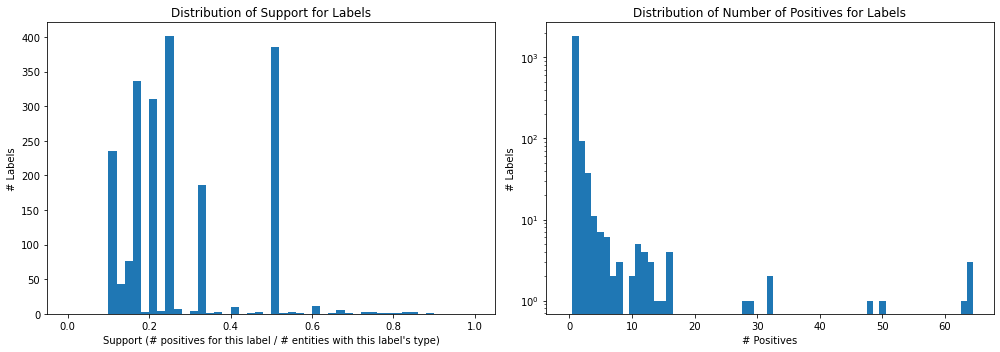

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q123480,'landlocked country'@en,P1198,'unemployment rate'@en,4.0,,Q11229,2.0,20.0,0.100000
346,Q123480,'landlocked country'@en,P1198,'unemployment rate'@en,3.0,,Q11229,3.0,20.0,0.150000
1421,Q179164,'unitary state'@en,P2855,'VAT-rate'@en,20.0,,Q11229,6.0,19.0,0.315789
2014,Q123480,'landlocked country'@en,P2884,'mains voltage'@en,230.0,,Q25250,12.0,20.0,0.600000
2046,Q63791824,'countries bordering the Baltic Sea'@en,P3000,'marriageable age'@en,18.0,,Q24564698,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
23,Q15079724,'white beer'@en,P2665,'alcohol by volume'@en,3.5,,Q2080811,1.0,10.0,0.100000
1415,Q7270,'republic'@en,P2884,'mains voltage'@en,220.0,,Q25250,6.0,22.0,0.272727
232,Q6256,'country'@en,P3001,'retirement age'@en,65.0,,Q24564698,12.0,105.0,0.114286
1414,Q3624078,'sovereign state'@en,P3270,'compulsory education (minimum age)'@en,6.0,,Q577,28.0,104.0,0.269231
2022,Q6256,'country'@en,P2997,'age of majority'@en,18.0,,Q24564698,64.0,105.0,0.609524


In [17]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, log_scale_positives = True)

### AIL - year

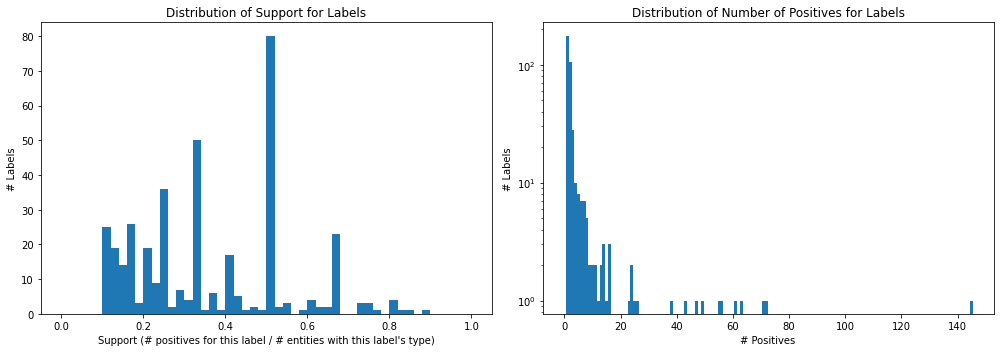

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q515,'city'@en,P571,'inception'@en,-3657.5,423.5,,,4.0,40.0,0.100000
55,Q630531,'French wine'@en,P571,'inception'@en,1962.5,1979,,,6.0,38.0,0.157895
161,Q7270,'republic'@en,P571,'inception'@en,,1638,,,7.0,22.0,0.318182
328,Q1549591,'big city'@en,P571,'inception'@en,331,,,,24.0,46.0,0.521739
378,Q10373548,'whisky distillery'@en,P571,'inception'@en,,,,,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
1,Q146470,'brandy'@en,P571,'inception'@en,,,,,1.0,10.0,0.100000
25,Q5,'human'@en,P569,'date of birth'@en,1360,1566.5,,,8.0,64.0,0.125000
248,Q3139487,'Denominación de Origen'@en,P571,'inception'@en,,,,,16.0,32.0,0.500000
367,Q5,'human'@en,P570,'date of death'@en,1409,,,,47.0,64.0,0.734375
340,Q131734,'brewery'@en,P571,'inception'@en,1809.5,,,,145.0,224.0,0.647321


In [18]:
plot_label_supports_and_positives(ail_year_file, ail_cols, log_scale_positives = True)

### AIL - quantity

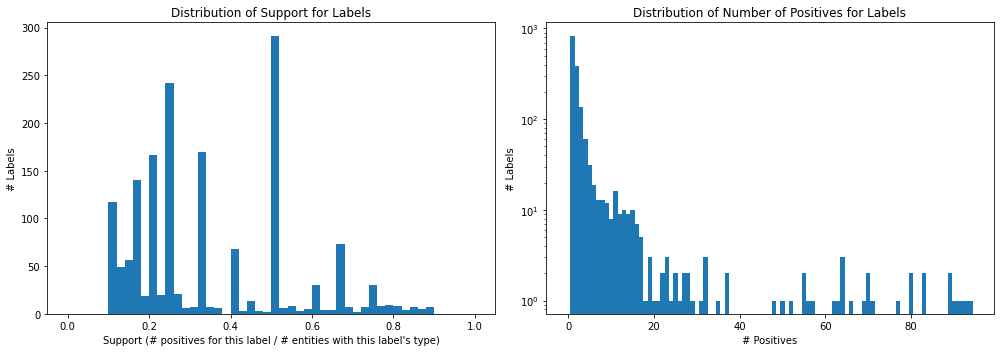

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q515,'city'@en,P1082,'population'@en,,5.121354e+06,,,4.0,40.0,0.100000
380,Q1549591,'big city'@en,P1082,'population'@en,,5.293773e+06,,,9.0,46.0,0.195652
1112,Q6256,'country'@en,P2884,'mains voltage'@en,225,2.350000e+02,,Q25250,50.0,105.0,0.476190
1539,Q7270,'republic'@en,P2131,'nominal GDP'@en,,1.617717e+11,,Q4917,15.0,22.0,0.681818
1632,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.050000e+00,,Q11229,94.0,105.0,0.895238



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
46,Q188604,'county of Hungary'@en,P1082,'population'@en,440707.0,,,,1.0,10.0,0.100000
137,Q6256,'country'@en,P3001,'retirement age'@en,63.9,65.625,,Q24564698,14.0,105.0,0.133333
811,Q6256,'country'@en,P3270,'compulsory education (minimum age)'@en,5.5,6.5,,Q24564698,28.0,105.0,0.266667
1428,Q6256,'country'@en,P2997,'age of majority'@en,17.5,18.5,,Q24564698,63.0,105.0,0.600000
1632,Q6256,'country'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229,94.0,105.0,0.895238


In [19]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, log_scale_positives = True)

### RELs

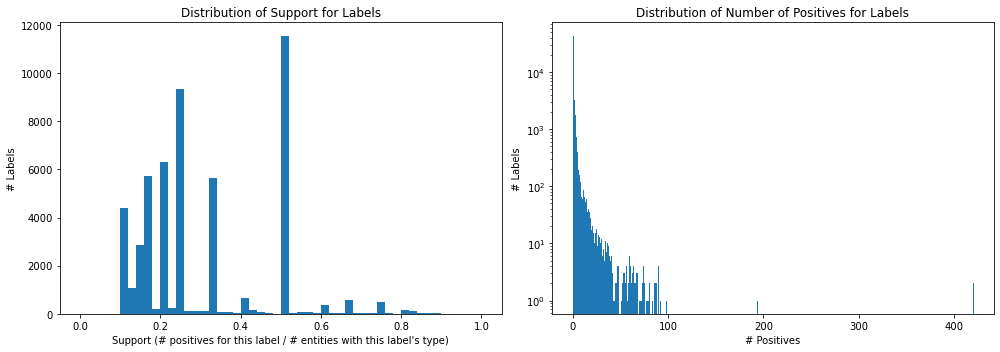

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
548,Q484170,'commune of France'@en,P131,'located in the administrative territorial ent...,Q12526,'Gironde'@en,7.0,70.0,0.100000
527,Q167270,'trademark'@en,P31,'instance of'@en,Q44,'beer'@en,15.0,86.0,0.174419
197,Q6256,'country'@en,P530,'diplomatic relation'@en,Q1246,'Kosovo'@en,32.0,105.0,0.304762
971,Q30041186,'Wikidata property related to online communiti...,P31,'instance of'@en,Q62589320,'Wikidata property for an identifier that does...,12.0,22.0,0.545455
1521,Q123480,'landlocked country'@en,P463,'member of'@en,Q1043527,'Multilateral Investment Guarantee Agency'@en,18.0,20.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
3127,Q146470,'brandy'@en,P112,'founded by'@en,Q26868740,'Nerses Tairyan'@en,1.0,10.0,0.100000
148,Q6256,'country'@en,P2853,'electrical plug type'@en,Q24288454,'NEMA 1-15'@en,22.0,105.0,0.209524
231,Q6256,'country'@en,P530,'diplomatic relation'@en,Q851,'Saudi Arabia'@en,43.0,105.0,0.409524
257,Q6256,'country'@en,P530,'diplomatic relation'@en,Q801,'Israel'@en,66.0,105.0,0.628571
0,Q10750129,'First Growth'@en,P31,'instance of'@en,Q10210,'white wine'@en,420.0,1078.0,0.389610


In [20]:
plot_label_supports_and_positives(rel_file, rel_cols, log_scale_positives = True)

### RAVLs

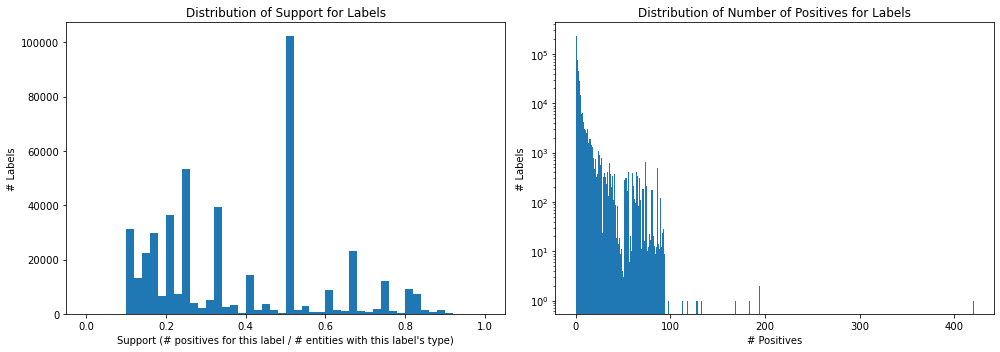

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
0,Q484170,'commune of France'@en,P131,'located in the administrative territorial ent...,Q6465,'department of France'@en,P1082,'population'@en,1463662,,,7.0,70.0,0.100000
96736,Q19829908,'Wikidata property for authority control for p...,P17,'country'@en,Q3624078,'sovereign state'@en,P3238,'trunk prefix'@en,0,,,11.0,61.0,0.180328
211953,Q6256,'country'@en,P47,'shares border with'@en,Q179164,'unitary state'@en,P2997,'age of majority'@en,18,,Q24564698,34.0,105.0,0.323810
381891,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q112099,'island nation'@en,P2219,'real gross domestic product growth rate'@en,5.0,,Q11229,57.0,104.0,0.548077
456764,Q123480,'landlocked country'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,Q24564698,18.0,20.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
6566,Q146470,'brandy'@en,P112,'founded by'@en,Q5,'human'@en,P569,'date of birth'@en,1833,,,1.0,10.0,0.100000
31524,Q131734,'brewery'@en,P17,'country'@en,Q63791824,'countries bordering the Baltic Sea'@en,P2884,'mains voltage'@en,230,,Q25250,27.0,224.0,0.120536
139562,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,Q24564698,53.0,242.0,0.219008
435343,Q6256,'country'@en,P530,'diplomatic relation'@en,Q112099,'island nation'@en,P3238,'trunk prefix'@en,0,,,79.0,105.0,0.752381
256947,Q10750129,'First Growth'@en,P31,'instance of'@en,Q8024923,'wine color'@en,P373,'Commons category'@en,White wine,,,420.0,1078.0,0.389610


In [21]:
plot_label_supports_and_positives(ravl_file, ravl_cols, log_scale_positives = True)

### RAILs

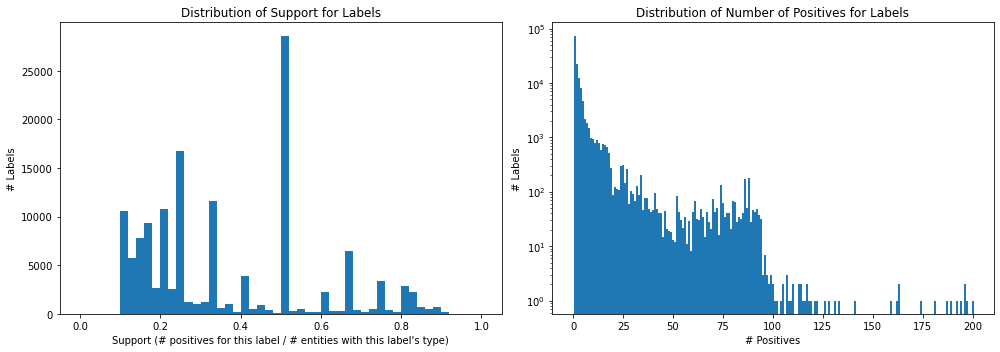

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q484170,'commune of France'@en,P131,'located in the administrative territorial ent...,Q6465,'department of France'@en,P2046,'area'@en,9517.8,,,Q712226,7.0,70.0,0.100000
35932,Q3624078,'sovereign state'@en,P1343,'described by source'@en,Q7725634,'literary work'@en,P577,'publication date'@en,,1938,,,20.0,104.0,0.192308
81361,Q55452870,'Wikidata property related to encyclopedias'@en,P17,'country'@en,Q6256,'country'@en,P2046,'area'@en,,2.58107e+06,,Q712226,28.0,81.0,0.345679
118157,Q6256,'country'@en,P530,'diplomatic relation'@en,Q1520223,'constitutional republic'@en,P2131,'nominal GDP'@en,,6.88423e+12,,Q4917,59.0,105.0,0.561905
139702,Q515,'city'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2299,'PPP GDP per capita'@en,,57625,,Q550207,36.0,40.0,0.900000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
1620,Q146470,'brandy'@en,P112,'founded by'@en,Q5,'human'@en,P569,'date of birth'@en,1682,,,,1.0,10.0,0.100000
22792,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P7295,'Gregorian calendar start date'@en,,1641.5,,,34.0,224.0,0.151786
68455,Q131734,'brewery'@en,P17,'country'@en,Q112099,'island nation'@en,P2046,'area'@en,,1.14127e+06,,Q712226,67.0,224.0,0.299107
21644,Q15075508,'beer brand'@en,P495,'country of origin'@en,Q6256,'country'@en,P571,'inception'@en,1640,,,,100.0,683.0,0.146413
139319,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.7275,,,,200.0,224.0,0.892857


In [22]:
plot_label_supports_and_positives(rail_file, rail_cols, log_scale_positives = True)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


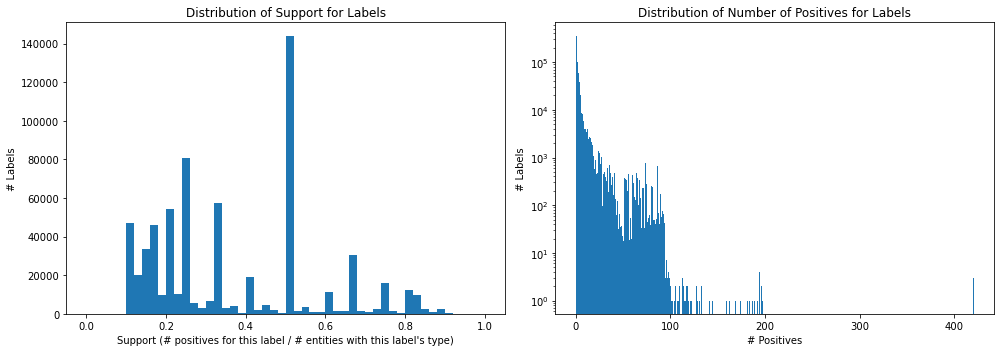

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
0,AVL,2.0,20.0,0.100000,Q123480,'landlocked country'@en,P1198,'unemployment rate'@en,4.0,,,,,,,,,,Q11229
551815,RAIL,7.0,36.0,0.194444,Q156362,'winery'@en,P131,'located in the administrative territorial ent...,,,,Q6465,'department of France'@en,P2046,'area'@en,8272.5,9517.8,,Q712226
6163,REL,36.0,104.0,0.346154,Q3624078,'sovereign state'@en,P463,'member of'@en,Q41550,'Organisation for Economic Cooperation and Dev...,,,,,,,,,
442719,RAVL,59.0,104.0,0.567308,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,2.9,,,Q11229
7226,REL,18.0,20.0,0.900000,Q123480,'landlocked country'@en,P463,'member of'@en,Q1043527,'Multilateral Investment Guarantee Agency'@en,,,,,,,,,



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
23,AVL,1.0,10.0,0.100000,Q15079724,'white beer'@en,P2665,'alcohol by volume'@en,3.5,,,,,,,,,,Q2080811
5724,REL,35.0,154.0,0.227273,Q4830453,'business'@en,P452,'industry'@en,Q869095,'brewing'@en,,,,,,,,,
5712,REL,70.0,224.0,0.312500,Q131734,'brewery'@en,P17,'country'@en,Q31,'Belgium'@en,,,,,,,,,
604428,RAIL,107.0,224.0,0.477679,Q131734,'brewery'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2131,'nominal GDP'@en,,1.99515e+12,,Q4917
5705,REL,420.0,1078.0,0.389610,Q10750129,'First Growth'@en,P31,'instance of'@en,Q10210,'white wine'@en,,,,,,,,,


In [23]:
plot_label_supports_and_positives(all_file, all_cols, log_scale_positives = True)

## Let's look at a subset of these labels since there are a lot of them here. 
Filter on type1 = Q44 (beer)

### Optional - create a file we can view in Excel
First let's create a smaller "all-labels" file just for type1=Q44 since this will be small enough that we can view the labels in Excel.

In [25]:
df = pd.read_csv(all_file, delimiter = '\t')
df = df.loc[df.loc[:,"type1"] == "Q44"]
type1_is_q44_all_file = "{}/filtered_all_analysis_type1_is_q44.tsv".format(output_dir)
df[all_cols].to_csv(path_or_buf = type1_is_q44_all_file, sep = '\t', index = False)

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


And again here are histograms of the label supports and positives...

In [31]:
type1 = "Q44" # can change this to another type and then re-run the below cells.

### AVL - string

In [42]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q44


### AVL - year

In [43]:
plot_label_supports_and_positives(avl_year_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q44


### AVL - quantity

In [44]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, type1 = type1)

There are no labels in the given file with type = Q44


### AIL - year

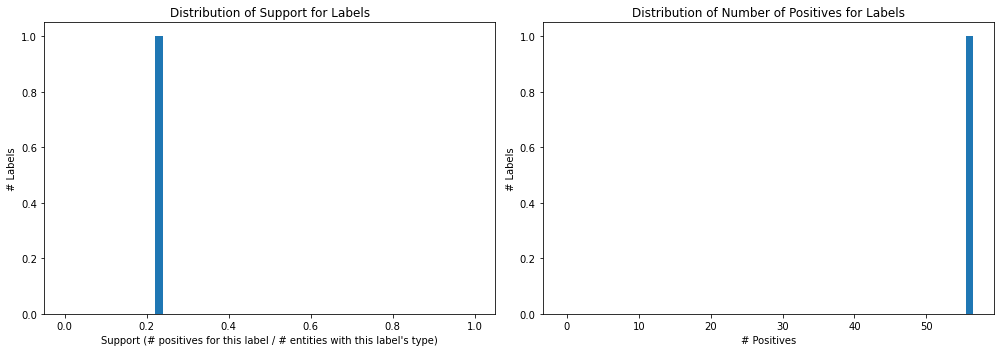

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
114,Q44,'beer'@en,P571,'inception'@en,1815.0,,,,56.0,242.0,0.231405



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
114,Q44,'beer'@en,P571,'inception'@en,1815.0,,,,56.0,242.0,0.231405


In [45]:
plot_label_supports_and_positives(ail_year_file, ail_cols, type1 = type1)

### AIL - quantity

In [46]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, type1 = type1)

There are no labels in the given file with type = Q44


### RELs

In [47]:
plot_label_supports_and_positives(rel_file, rel_cols, type1 = type1)

There are no labels in the given file with type = Q44


### RAVLs

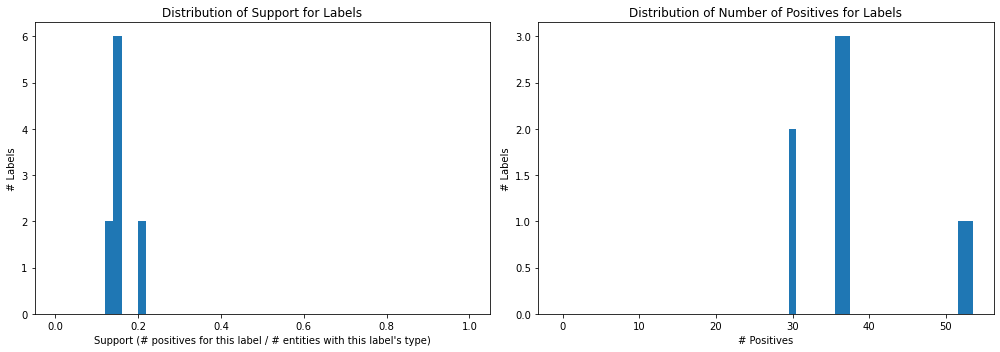

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
31672,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P3270,'compulsory education (minimum age)'@en,6,,Q24564698,30.0,242.0,0.123967
59143,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P2884,'mains voltage'@en,230,,Q25250,36.0,242.0,0.148760
63834,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,230,,Q25250,37.0,242.0,0.152893
139383,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P2997,'age of majority'@en,18,,Q24564698,52.0,242.0,0.214876
139562,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,Q24564698,53.0,242.0,0.219008



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
31672,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P3270,'compulsory education (minimum age)'@en,6,,Q24564698,30.0,242.0,0.123967
59143,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P2884,'mains voltage'@en,230,,Q25250,36.0,242.0,0.148760
63834,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2884,'mains voltage'@en,230,,Q25250,37.0,242.0,0.152893
139383,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P2997,'age of majority'@en,18,,Q24564698,52.0,242.0,0.214876
139562,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,Q24564698,53.0,242.0,0.219008


In [48]:
plot_label_supports_and_positives(ravl_file, ravl_cols, type1 = type1)

### RAILs

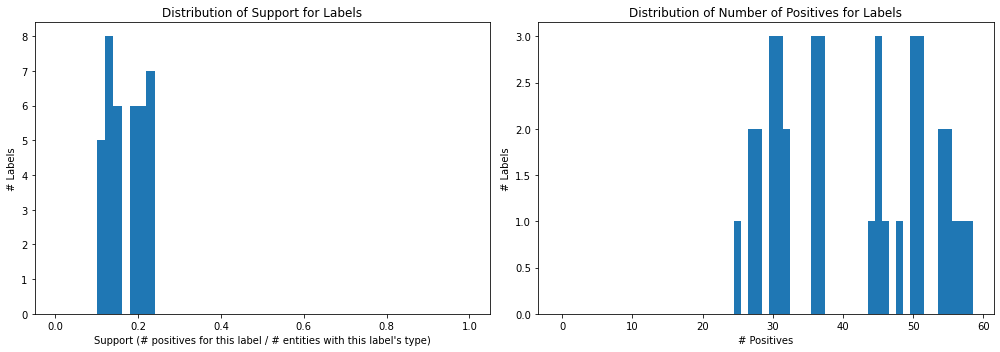

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
3392,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P1082,'population'@en,,7.01416e+07,,,25.0,242.0,0.103306
14531,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2250,'life expectancy'@en,67.586,,,Q577,31.0,242.0,0.128099
35696,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2131,'nominal GDP'@en,,1.99515e+12,,Q4917,45.0,242.0,0.185950
46468,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1198,'unemployment rate'@en,1.45,15,,Q11229,51.0,242.0,0.210744
49464,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229,58.0,242.0,0.239669



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
3392,Q44,'beer'@en,P17,'country'@en,Q6256,'country'@en,P1082,'population'@en,,7.01416e+07,,,25.0,242.0,0.103306
14531,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2250,'life expectancy'@en,67.586,,,Q577,31.0,242.0,0.128099
35696,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2131,'nominal GDP'@en,,1.99515e+12,,Q4917,45.0,242.0,0.185950
46468,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1198,'unemployment rate'@en,1.45,15,,Q11229,51.0,242.0,0.210744
49464,Q44,'beer'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229,58.0,242.0,0.239669


In [49]:
plot_label_supports_and_positives(rail_file, rail_cols, type1 = type1)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


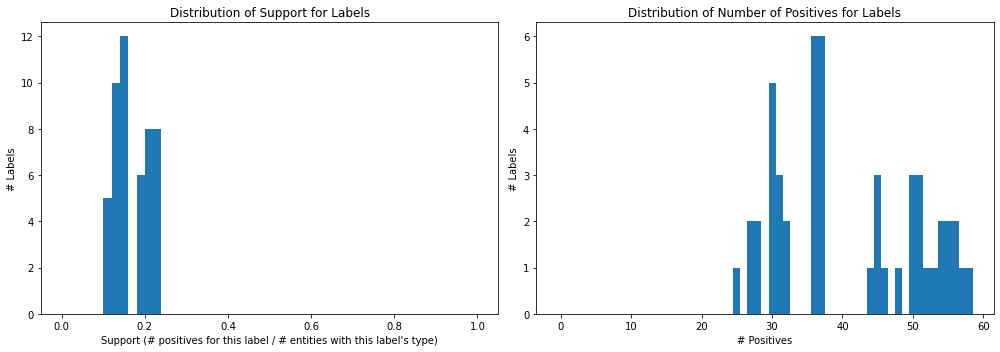

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
519126,RAIL,25.0,242.0,0.103306,Q44,'beer'@en,P17,'country'@en,,,,Q6256,'country'@en,P1082,'population'@en,,7.01416e+07,,
530483,RAIL,32.0,242.0,0.132231,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2573,'number of out-of-school children'@en,,817670,,
551617,RAIL,46.0,242.0,0.190083,Q44,'beer'@en,P17,'country'@en,,,,Q6256,'country'@en,P2046,'area'@en,,2.58107e+06,,Q712226
198142,RAVL,53.0,242.0,0.219008,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,,Q24564698
565198,RAIL,58.0,242.0,0.239669,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
519126,RAIL,25.0,242.0,0.103306,Q44,'beer'@en,P17,'country'@en,,,,Q6256,'country'@en,P1082,'population'@en,,7.01416e+07,,
530483,RAIL,32.0,242.0,0.132231,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2573,'number of out-of-school children'@en,,817670,,
551617,RAIL,46.0,242.0,0.190083,Q44,'beer'@en,P17,'country'@en,,,,Q6256,'country'@en,P2046,'area'@en,,2.58107e+06,,Q712226
198142,RAVL,53.0,242.0,0.219008,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,18,,,Q24564698
565198,RAIL,58.0,242.0,0.239669,Q44,'beer'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P2219,'real gross domestic product growth rate'@en,-7.8,9.05,,Q11229


In [50]:
plot_label_supports_and_positives(all_file, all_cols, type1 = type1)